# Python Code for Deep Learning Regularization and Optimization

The following material was initially prepared as a lecture for <strong>CSCI 4701: Deep Learning (Spring 2025)</strong> course at ADA University. It is highly based on the examples given in different chapters of the <a href='https://d2l.ai/'>Dive Deep into Deep Learning</a> book. The notebook is the continuation of my lecture series on deep learning: <a href='https://shahaliyev.org/writings/backprop'>Python Code from Derivatives to Backpropagation</a>, <a href='https://shahaliyev.org/writings/neural_network'>Python Code from Neuron to Neural Network</a> and <a href='https://shahaliyev.org/writings/cnn-pytorch'> PyTorch Code from Kernel to Convolutional Neural Network</a>.

### Table of Contents

- Weight Decay
- Dropout
- Exploding & Vanishing Gradients
- Xavier / He Parameter Initialization
- Local Minima & Saddle Point
- Learning Rate
- Stochastic Gradient Descent (SGD)
- Momentum
- RMSProp
- Adam
- CIFAR-10 Dataset
- Training Efficient Model
- Hyperparameter Tuning

Our artificial neural networks which we built from scratch in previous classes were in their simplistic form and very inefficient, causing slow and less accurate training. In this notebook we will introduce many regularization/optimization techniques which will improve our model performance.

The prerequisite of this course, Machine Learning, should have introduced the problems of **underfitting** and **overfitting** (See [StatQuest video](https://www.youtube.com/watch?v=EuBBz3bI-aA) and [MLU vizualization](https://mlu-explain.github.io/bias-variance/) on **bias** and **variance**). [Regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) techniques like _weight decay_ tackle high variance (overfitting) without getting more high-quality data, which is often costly.

## Weight Decay

Loss function $L$ (e.g. MSE) can be regularized by adding to it regularizer $R$, where λ is the regularization hyperparameter that controls the strength of the regularization function (we saw `learning rate` hyperparameter previously).

$$ L(w, b) + \lambda R(w) $$

Even if there are many different regularizers for loss, the most common and practically efficient one is $l_2$ (ridge) regularization, which is called [weight decay](https://d2l.ai/chapter_linear-regression/weight-decay.html) in the context of Deep Learning. It has the following formula:

$$ L(w, b) + \frac{\lambda}{2} \sum_{i=1}^{d} w_i^2 $$

As can be seen, the eventual loss increases for higher weight values. Hence, backpropagation will not only reduce the chosen loss function (e.g. MSE) but will also strive for smaller weights. You can imagine that in the limit weights approach zero, reducing the impact of the corresponding neuron on the outcome. Less neuron impact means getting simpler function to avoid overfitting.

When $λ$ is zero we restore the original loss function, when $λ$ is large it forces shifts the attention from the original loss function to $R$, constraining $w$ further. We divide by $2$ so that when the derivative of the square will be found, it will get cancelled out with it, simplifying our derivative expression to $ λw_i $. Recall linear algebra that we are finding the square of the euclidean [norm](https://d2l.ai/chapter_preliminaries/linear-algebra.html#subsec-lin-algebra-norms) of $d$-dimensional vector, again to ease computation: we remove the burden of finding the square root in $l_2$.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We will now implement the simplified and clearer version of the example noted in the [d2l book](https://d2l.ai/chapter_linear-regression/weight-decay.html). We will generate random data corresponding to an N-dimensional linear function, where each data point will be shifted by some amount of noise.

In [3]:
def generate_data(samples=100, N=100, test_size=0.5, b=0.05, scale=0.01):
  X = torch.randn(samples, N)
  w = torch.randn(N, 1) * scale # scaling will ease training
  n = torch.randn(samples, 1) * scale # noise is not a bias
  y = torch.matmul(X, w) + n + b

  size = int(samples * test_size)
  X_train, X_test = X[:-size], X[-size:]
  y_train, y_test = y[:-size], y[-size:]

  return X_train, X_test, y_train, y_test

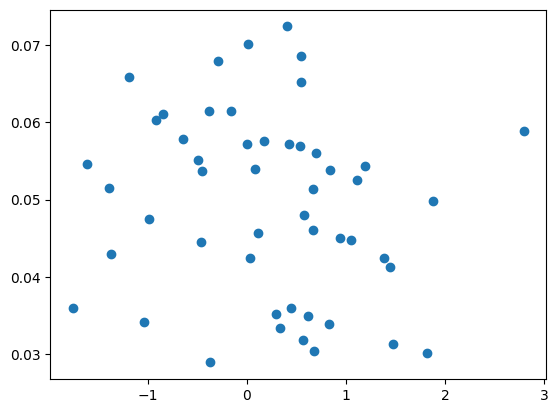

In [4]:
X_train, _, y_train, _ = generate_data(100, 1) # 1D input for plotting
plt.scatter(X_train, y_train);

We will now generate a bigger dataset (both in the number of samples and dimensions), a good deal of which will be used for testing (so that we can illustrate overfitting). We will then create simple `Linear Regression` model and train it. When training we will implement the $l_2$ regularization discussed above to see how it affects the test loss.

In [5]:
X_train, X_test, y_train, y_test = generate_data(samples=100, N=200, test_size=0.5, scale=0.01)

In [6]:
def train(num_epochs=1000, lambda_=0.1):
  model = nn.LazyLinear(1)
  optimizer = optim.SGD(model.parameters(), lr=0.001)
  mse = nn.MSELoss()

  # needed for plotting
  train_losses = []
  test_losses = []

  for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    # regularization
    l2 = sum(p.pow(2).sum() for p in model.parameters())/2
    loss = mse(pred, y_train) + lambda_ * l2 # see formula above
    loss.backward()
    optimizer.step()

    # inference during training
    with torch.no_grad():
      test_pred = model(X_test)
      test_loss = mse(test_pred, y_test)

    # needed for plotting
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    if epoch % 200 == 0:
      print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

  # plotting
  plt.figure(figsize=(6, 4))
  plt.plot(range(num_epochs), train_losses, label='Train Loss')
  plt.plot(range(num_epochs), test_losses, label='Test Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

Try to understand why the line which calculates regularization function's output has two `sum` functions: `l2 = sum(p.pow(2).sum() for p in model.parameters())/2`. We have plotting logic in the function above for demonstration purposes, and we will give different $λ$ values to customize our regularizer $R$ ($λ$=0 implies no regularization).

Epoch 0, Train Loss: 0.3230, Test Loss: 0.4413
Epoch 200, Train Loss: 0.0165, Test Loss: 0.3265
Epoch 400, Train Loss: 0.0023, Test Loss: 0.3051
Epoch 600, Train Loss: 0.0005, Test Loss: 0.2979
Epoch 800, Train Loss: 0.0002, Test Loss: 0.2950


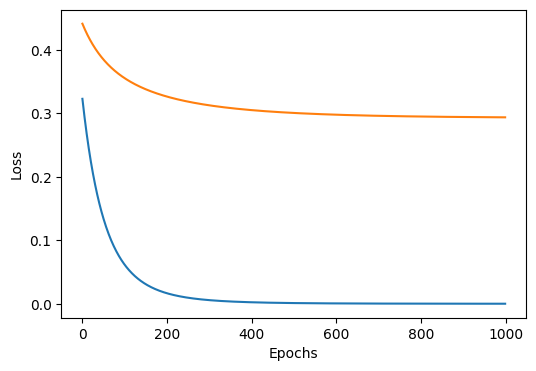

In [7]:
train(lambda_=0.0) # no regularization

Epoch 0, Train Loss: 1.1423, Test Loss: 0.2795
Epoch 200, Train Loss: 0.1009, Test Loss: 0.0429
Epoch 400, Train Loss: 0.0218, Test Loss: 0.0185
Epoch 600, Train Loss: 0.0116, Test Loss: 0.0153
Epoch 800, Train Loss: 0.0103, Test Loss: 0.0150


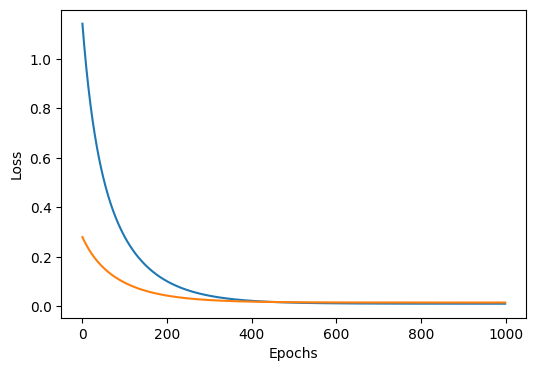

In [8]:
train(lambda_=5.0) # with regularization

## Dropout

The more complicated the model is, the more chance it has to overfit to the train data. In order to improve generalization ability of our model to the unseen data, we may aim for a simpler model. Regularization with weight decay achieved that to some degree but it's not the only solution. [Srivastava et al.](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) building on top of the previous idea developed by [Bishop](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/bishop-tikhonov-nc-95.pdf) came up with the concept called **Dropout**. Dropout literally drops out some neurons during training by setting their activations to zero, which is illustrated in the [figure 5.6.1](https://d2l.ai/chapter_multilayer-perceptrons/dropout.html) of d2l book below.

![Dropout](https://d2l.ai/_images/dropout2.svg)

In [9]:
X = torch.arange(1,7)
print("Initial layer activations:", X)

prob = 0.5 # try out different values between 0 and 1
mask = (torch.rand(X.shape) > prob ).float()
print(f"Random mask with dropout probability {prob}: {mask}")

X_dropout = X * mask
print(f"Layer activations after dropout {X_dropout}")

X_dropout_scaled = X_dropout / (1.0 - prob + 1e-9)
print(f"Scaled activations after dropout {X_dropout_scaled}")

Initial layer activations: tensor([1, 2, 3, 4, 5, 6])
Random mask with dropout probability 0.5: tensor([0., 0., 0., 0., 1., 1.])
Layer activations after dropout tensor([0., 0., 0., 0., 5., 6.])
Scaled activations after dropout tensor([ 0.,  0.,  0.,  0., 10., 12.])


The idea behind dropout is that it injects noise to the network during training. If a model can achieve good accuracy with noise, that probably implies that it has learned a more generalizable function. Dropping out certain proportion of neurons in each iteration basically guides the model to train a smaller network. Scaling is done to so that the expected sum of activations will roughly remain the same to compensate for missing activations. See [Andrew Ng's explanation](https://www.youtube.com/watch?v=ARq74QuavAo) to get a better intuition of dropout. While watching the video, note that in other framework implementations `keep_prob` can be used for dropout, which keeps all the nodes in case of being set to `1.0`. In the `PyTorch` implementation, the same is achieved by doing the opposite and setting the probability to `0.0`. Although a useful technique, dropout should be used carefully in order to not hurt the overall performance of the model.

We will now implement a `Dropout` class (an equivalent of `nn.Dropout` module of `PyTorch`) and build MLP. Dropout probability is usually set higher for bigger layers and layer closer to the input (but not the input layer, as it doesn't make sense to drop out the input features). Once the training is over, dropout is usually turned off. However, it can also be used in the test time as a mean of estimating how uncertain the neural network is.

In [10]:
class Dropout(nn.Module):
  def __init__(self, prob):
    super().__init__()
    assert 0 <= prob <= 1
    self.prob = prob
    self.epsilon = 1e-8

  def forward(self, X):
    if self.training: # model.eval() will turn it off
      mask = (torch.rand_like(X) > self.prob).float()
      X = X * mask / (1.0 - self.prob + self.epsilon)
    return X

In [11]:
model = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(256),
    nn.ReLU(),
    Dropout(0.5), # nn.Dropout(0.5)
    nn.LazyLinear(128),
    nn.ReLU(),
    Dropout(0.3), # nn.Dropout(0.3)
    nn.LazyLinear(10)
)

So far we have looked at two regularization techniques: $l_2$ regularization and dropout. There is also a technique called _early stopping_ which simply stops the training when validation loss stops improving. Regulization methods had the goal of reducing overfitting, and thus increasing the generalization ability of our model. Additionally, we would like to optimize our models to efficiently minimize the loss and converge to a good solution.

## Exploding & Vanishing Gradients

When building neural network from scratch, we have been initilializing our parameters randomly. By following a certain guideline when initializing weights, however, it is possible to influence the speed and convergence of our training. Poor parameter initialization can cause problems like **exploding and vanishing gradients**.

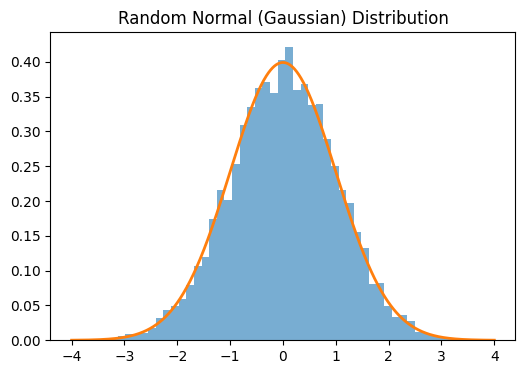

In [12]:
import scipy.stats as stats

W = torch.normal(mean=0, std=1, size=(10000,))
x = np.linspace(-4, 4, 1000)
pdf = stats.norm.pdf(x, 0, 1)

plt.figure(figsize=(6, 4))
plt.hist(W.numpy(), bins=50, density=True, alpha=0.6)
plt.plot(x, pdf, linewidth=2)
plt.title('Random Normal (Gaussian) Distribution');

By chain rule, we know that the node gradients are multiplied. Hence, multiplying many gradients that have big value along our neural network will explode the final gradient, resulting in unnessarily big jumps and missing the minimum of the function and thus not converging. The opposite is also true: if the gradients are too small then multiplying lost of small values will result in a number that is almost zero, causing the vanishing gradient problem. With gradients almost zero, values during backpropagation will not get updated and the learning will stop. Below are some examples from the textbook.

In [13]:
W = torch.normal(mean=0, std=1, size=(3, 3)) # Gaussian distribution matrix

num_epochs = 20
for _ in range(num_epochs):
  W = W @ torch.normal(mean=0, std=1, size=(3, 3)) # matrix multiplication of N such matrices
print('Exploding gradients:\n', W)

Exploding gradients:
 tensor([[-2657.0173,   939.6129,  3719.5845],
        [-2549.2896,   842.5388,  3360.0208],
        [ -697.6809,   168.5173,   699.8742]])


We will now take three activation functions (`sigmoid`, `relu`, `leaky_relu`) and plot their functions together with the graident values. Try to interpret what the plots mean.

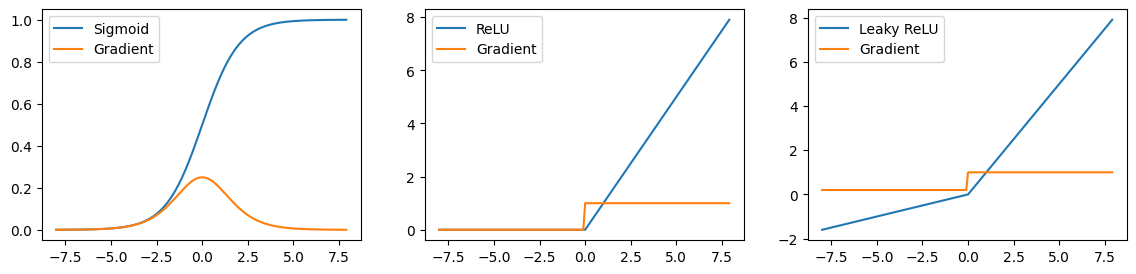

In [14]:
plt.figure(figsize=(14,3))

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y_sigmoid = torch.sigmoid(x)
y_sigmoid.backward(torch.ones_like(x))

plt.subplot(1, 3, 1)
plt.plot(x.detach().numpy(), y_sigmoid.detach().numpy(), label='Sigmoid')
plt.plot(x.detach().numpy(), x.grad.numpy(), label='Gradient')
plt.legend()

x.grad.zero_()
y_relu = torch.relu(x)
y_relu.backward(torch.ones_like(x))

plt.subplot(1, 3, 2)
plt.plot(x.detach().numpy(), y_relu.detach().numpy(), label='ReLU')
plt.plot(x.detach().numpy(), x.grad.numpy(), label='Gradient')
plt.legend()

x.grad.zero_()
y_leaky_relu = torch.nn.functional.leaky_relu(x, 0.2)
y_leaky_relu.backward(torch.ones_like(x))

plt.subplot(1, 3, 3)
plt.plot(x.detach().numpy(), y_leaky_relu.detach().numpy(), label='Leaky ReLU')
plt.plot(x.detach().numpy(), x.grad.numpy(), label='Gradient')
plt.legend();

As can be seen, for the sigmoid function, the gradients are almost zero for low and high ends of the function (saddle points) due to its gradient being $σ(x)(1−σ(x))$. Since the AlexNet paper, for the reason of vanishing gradient problem, `relu` activation is usually preferred over `sigmoid`. Note that when the output is mapped to the negative values on the `relu`, derivates become zero, still causing so-called dying relu problem, which can be solved to some degree with the help of `leaky_relu` where the gradients do not become exactly zero when the output is mapped to the negative value. Still, in practice, `relu` is often robust.

## Xavier / He Parameter Initialization



For simplicity, let's take a simple neural network layer without activation and bias. We know that the next layer's values will be affected by the following sum: $o_{i} = \sum_{j=1}^{n_\textrm{in}} w_{ij} x_j$. Let's also assume that the weights are initializated with the Guassian distribution with zero mean. Then we can calculate the Expectation $E$ (mean). Recall that $E$ of a random variable represents the average value you would expect if you repeated experiment many times.

\begin{split}\begin{aligned}
    E[o_i] & = \sum_{j=1}^{n_\textrm{in}} E[w_{ij} x_j] = \sum_{j=1}^{n_\textrm{in}} E[w_{ij}] E[x_j] = \sum_{j=1}^{n_\textrm{in}} 0 \cdot E[x_j] = 0
\end{aligned}\end{split}

Recall that variance measures the spread of data around its mean. Squaring is applied so that negative and positive values will not cancel each others out. Considering that weights and inputs are independent:

\begin{split}\begin{aligned}
    \textrm{Var}[o_i] & = E[o_i^2] - (E[o_i])^2 = \sum_{j=1}^{n_\textrm{in}} E[w^2_{ij} x^2_j] - 0  = \sum_{j=1}^{n_\textrm{in}} E[w^2_{ij}] E[x^2_j] = n_\textrm{in} \sigma^2 \gamma^2
\end{aligned}\end{split}

It implies that the variance of the output will be proportional to the number of input neurons.

In [ ]:
n_out = 10
for n_in in [10**i for i in range(5)]:
  X = torch.randn(n_in)
  W = torch.normal(mean=0, std=1, size=(n_in, n_out))
  O = X @ W
  print(f'n_in: {n_in}, var(o): {O.var().item()}')

n_in: 1, var(o): 0.6714984774589539
n_in: 10, var(o): 2.69901967048645
n_in: 100, var(o): 45.740028381347656
n_in: 1000, var(o): 1667.195068359375
n_in: 10000, var(o): 12416.2021484375


To mitigate the exploding gradient problem, an obvious trick is to We can achieve the stability of variance by ensuring that $n_\textrm{in} \sigma^2 = 1$. Hence we retrieve the standard deviation to be $\sigma = \sqrt{\frac{1}{n_\textrm{in}}}$. The paper called [Understanding the difficulty of training deep feedforward neural networks](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) by _Xavier Glorot_ and _Yoshua Bengio_ propose this solution together with considering the case for backpropagation. With the same logic, we can realize that to keep the gradient variance consistent, we should ensure $n_\textrm{out} \sigma^2 = 1$, where $n_\textrm{out}$ is the number of output neurons. To satisfy both cases, we simply average the variance scaling: $(n_\textrm{in} + n_\textrm{out}) \sigma^2 = 1$ or equivalently $\sigma = \sqrt{\frac{2}{n_\textrm{in} + n_\textrm{out}}}$.

**Xavier initialization** is mainly used for `sigmoid` and `tanh` activations. The paper [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/pdf/1502.01852) addresses rectified non-linearities. As `relu` function doesn't struggle with the vanishing gradient problem, the backpropagation doesn't have much effect on the variance. Hence Kaiming **He initialization** gets the form of $\sigma = \sqrt{\frac{2}{n_\textrm{in}}}$.


In [ ]:
n_out = 10
for n_in in [10**i for i in range(5)]:
  X = torch.randn(n_in)
  W = torch.normal(mean=0, std=np.sqrt(2.0/n_in), size=(n_in, n_out))
  O = X @ W
  print(f'n_in: {n_in}, var(o): {O.var().item()}')

n_in: 1, var(o): 0.12620338797569275
n_in: 10, var(o): 2.6602299213409424
n_in: 100, var(o): 2.959010124206543
n_in: 1000, var(o): 2.462198257446289
n_in: 10000, var(o): 2.8828887939453125


## Local Minima & Saddle Point

When minimizing the loss with gradient descent, we often deal with complicated functions with local and global minimums. When we are in local minima, we need certain noise to kick our parameter out of it so that we can find global minimum value for the loss. It is also possible to have a function where the gradients almost disappear (vanish), yet it is not a local or global minima. Optimization will not improve when we are at that point of the function due to very small gradients. We will plot both of the mentioned cases in 2D, but they can be extended to higher dimensions. For example, the function $f(x,y)=x^2-y^2$ indeed looks like a horse saddle when plotted, with its saddle point at $(0,0,0)$, hence the terminology. Saddle points are more frequent than local minima.

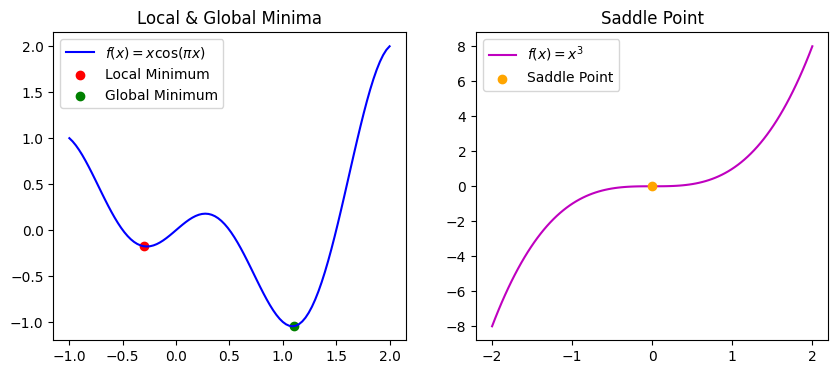

In [ ]:
f1 = lambda x: x * np.cos(np.pi * x)
f2 = lambda x: x**3

x1 = np.linspace(-1, 2, 100)
y1 = f1(x1)

local_min = (-0.3, f1(-0.3))
global_min = (1.1, f1(1.1))

x2 = np.linspace(-2, 2, 100)
y2 = f2(x2)

saddle_point = (0.0, f2(0.0))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(x1, y1, label=r'$f(x) = x \cos(\pi x)$', color='b')
axs[0].scatter(*local_min, color='r', label="Local Minimum")
axs[0].scatter(*global_min, color='g', label="Global Minimum")
axs[0].legend()
axs[0].set_title("Local & Global Minima")

axs[1].plot(x2, y2, label=r'$f(x) = x^3$', color='m')
axs[1].scatter(*saddle_point, color='orange', label="Saddle Point", zorder=3)
axs[1].legend()
axs[1].set_title("Saddle Point");

## Learning Rate

We have seen from previous experiments how learning rate can affect the training process. When the learning rate is low, parameters take smaller steps towards the minimum, and training becomes slow. When the learning rate is high, it can overshoot the local minima and may even never converge. Therefore, it is common to use a **learning rate scheduler** which schedules the learning rate values to initially take larger steps to speed up the training, but as the parameter values approach local minima, the scheduler gradually reduces the learning rate to avoid overshooting. For example, we can reduce the learning rate by a factor of `0.1` or so every `N` epochs. We can simulate the gradient descent in a 2D plot to illustrate the impact of different learning rates.

In [ ]:
def gradient_descent(f, grad_f, learning_rate, initial_point, num_steps):
  path = [initial_point]
  x = initial_point
  for _ in range(num_steps):
    grad = grad_f(x)
    x -= learning_rate * grad
    path.append(x)
  return np.array(path)

def plot_descent(f, grad_f, point, steps, start, end, learning_rates=[0.1, 0.3, 0.9, 1.0], figsize=(14,4)):
  x_vals = np.linspace(start, end, 100)
  y_vals = f(x_vals)

  fig, axs = plt.subplots(1, len(learning_rates), figsize=figsize)
  for i, lr in enumerate(learning_rates):
    path = gradient_descent(f, grad_f, lr, point, steps)
    axs[i].plot(x_vals, y_vals, color='b')
    axs[i].plot(path, f(path), marker='o', label=f'LR = {lr}', color=[1.0, 0.5, 0.5])
    axs[i].set_title(f'LR = {lr}')

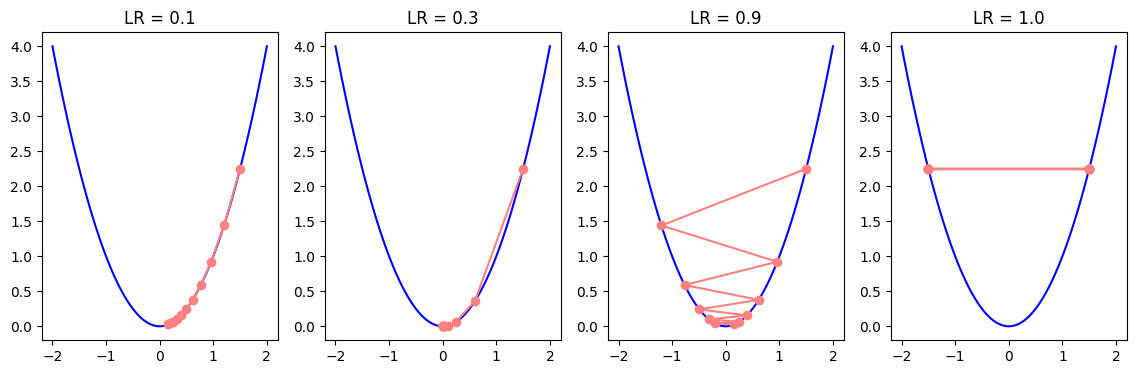

In [ ]:
f = lambda x: x**2
grad_f = lambda x: 2*x

plot_descent(f, grad_f, 1.5, 10, -2, 2)

## Stochastic Gradient Descent (SGD)

As mentioned before, it is possible for the parameters to get stuck in the local minima. A slightly modified version of the gradient descent, the minibatch [Stochastic Gradient Descent (SGD)](https://www.youtube.com/watch?v=vMh0zPT0tLI) has the ability to avoid local minima, as the variation of gradients in the minibatches bring noise and affect the parameter update. In SGD, instead of averaging the gradients of all data (batch) samples, we randomly choose only a single sample to approximate the average gradient. In case of **minibatch SGD**, we choose a small data subset (minibatch) instead of a single data point (SGD) or all data points (BGD) and average the minibatch gradients to approximate the average of full batch gradients.

In the examples below, we can see how different values of learning rates may postiviely or negatively influence the outcome depending on whether we are close to the local or global minima.

In [ ]:
c = np.array(0.15 * np.pi)
f = lambda x: x * np.cos(c * x)
grad_f = lambda x: np.cos(c * x) - c * x * np.sin(c * x)

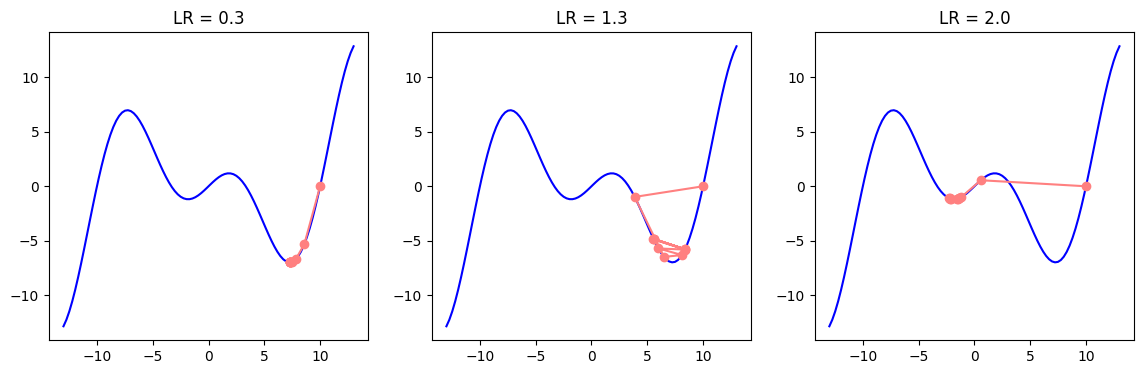

In [ ]:
plot_descent(f, grad_f, point=10, steps=10, start=-13, end=13, learning_rates=[0.3, 1.3, 2.0])

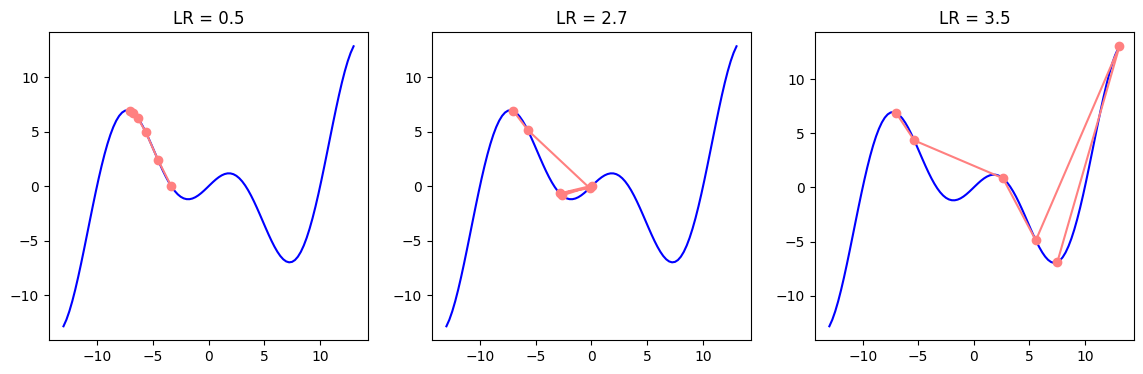

In [ ]:
plot_descent(f, grad_f, point=-7, steps=5, start=-13, end=13, learning_rates=[0.5, 2.7, 3.5])

## Momentum

We have observed that the learning rate is sensitive to small changes in its values. We can look at the direction of the gradient and encourage the learning rate to move smoothly in that direction (e.g. instead of oscillating a lot in a zig-zag pattern). It can be achieved with **momentum**, which adds a velocity term with acceleration to parameter updates. It behaves similar to how a ball would roll down a hill. Momentum builds speed as we move in the direction of the gradient, helping the training converge faster and more smoothly. This explanation, however, is oversimplistic. If you have a good mathematical background, you can find a nice demo and better explanation of momentum in this [distill article](https://distill.pub/2017/momentum/).

Recall that gradient descent for parameter $\theta$ had the following formula where $\nabla_{\theta} L(\theta_t)$ is gradient of loss and $\eta $ is learning rate:

$$ \theta_{t+1} = \theta_t - \eta \nabla_{\theta} L(\theta_t)$$

Momentum has a _velocity_ term $v$ which accumulates the values of previous gradients. It is also scaled by a momentum hyperparamter $\beta$ where $\beta \in (0, 1)$. Unlike  $\eta$ (learning rate hyperparamter), $\beta$ is usually set to $0.9$. Gradient update instead of pointing towards the direction of steepest descent on a single instance, becomes the direction of a weighted average of previous gradients. Momentum will play the role of an accelerator, From this point on, and parameters will be updated by the accumulated gradient value.

$$ v_t = \beta v_{t-1} +\nabla_{\theta} L(\theta_t) \\
\theta_{t+1} = \theta_t - \eta v_t $$

You will usually see a slighly modified version of the velocity, which scales the current gradient by $(1-\beta)$:

$$ v_t = \beta v_{t-1} + (1 - \beta)\nabla_{\theta} L(\theta_t)$$

You can imagine $\beta$ value to be an averaging factor. As the gradients accumulate, we may want to give less weight to the current gradient, which $1-\beta$ achieves. We can also notice that $\beta=0.0$ will turn off the momentum update and restore the original gradient descent, when $\beta=1.0$ would completely remove the effect of the gradient update. For this reason, you will see values for the momentum hyperparameter to be $0.99$ or even $0.999$ but never $1.0$.

In [ ]:
def gradient_descent(f, grad_f, learning_rate, initial_point, num_steps, momentum=0.9):
  assert momentum <= 1 and momentum >= 0
  path = [initial_point]
  x = initial_point

  beta = momentum
  v = 0.0
  for _ in range(num_steps):
    grad = grad_f(x)
    v = beta * v + (1 - beta) * grad
    x -= learning_rate * v
    path.append(x)
  return np.array(path)

def plot_descent(f, grad_f, point, steps, start, end, learning_rate, momentums=[0.1, 0.5, 0.9], figsize=(14,4)):
  x_vals = np.linspace(start, end, 100)
  y_vals = f(x_vals)

  fig, axs = plt.subplots(1, len(momentums), figsize=figsize)
  for i, momentum in enumerate(momentums):
    path = gradient_descent(f, grad_f, learning_rate, point, steps, momentum)
    axs[i].plot(x_vals, y_vals, color='b')
    axs[i].plot(path, f(path), marker='o', label=f'M = {momentum}', color=[1.0, 0.5, 0.5])
    axs[i].set_title(f'M = {momentum}')

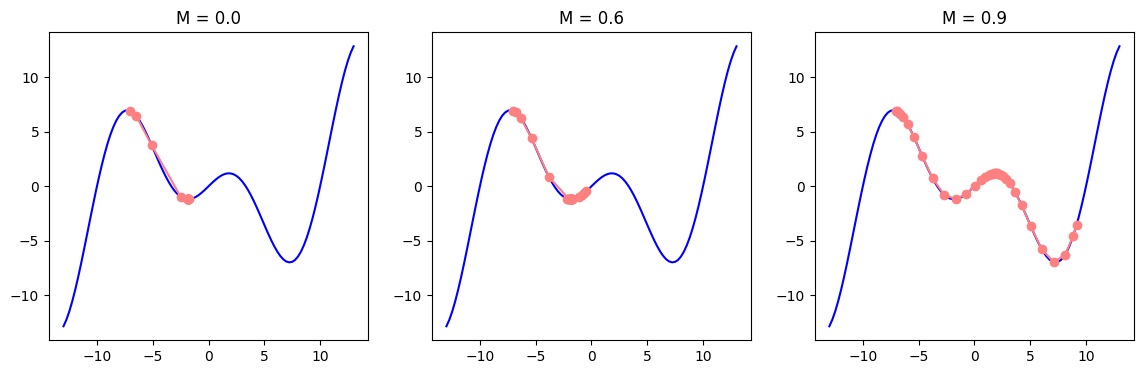

In [ ]:
plot_descent(f, grad_f, point=-7, steps=35, start=-13, end=13, learning_rate=1.1, momentums=[0.0, 0.6, 0.9])

## RMSProp

We can further optimize learning with **RMSProp** algorithm. RMSProp adjusts the parameter step size based on the historical magnitude of the parameter gradients. For that, step size (learning rate) is divided by a running average of squared gradients. This helps to avoid large updates in regions where gradients are large, while allowing for bigger steps in flatter regions of the function. Squaring and then desquaring (finding the square root) is a common technique (similar to finding MSE or standard deviation) which deals with negative values. RMSProp has the common abbreviation as MSE: the algorithm's full title is Root Mean Squared Propagation. The state $s$ in the formula below (which should seem familiar) holds the running average of squared gradients, which is then used to scale the learning rate for each parameter:

$$s_t = \gamma s_{t-1} + (1 - \gamma) \nabla_{\theta} L(\theta_t)^2$$

The updated parameter $\theta$ is then divided by the square root of this state vector. To avoid division by zero and achieve numerical stability $ϵ$ (a very small number approaching zero) is added. The term $\sqrt{s_t}$ represents the root of the running average of squared gradients, normalizing the gradient for each parameter.

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{s_t} + \epsilon} \nabla_{\theta} L(\theta_t)$$

RMSprop often performs well when dealing with noisy or sparse gradients, and the parameter $\gamma$ typically ranges between $0.9$ and $0.99$. Again note that RMSProp updates each parameter individually. The formula and all may seem complicated, yet the reasoning is very simple: you adjust the learning rate of each parameter by its past gradient. If the gradient was big, learning rate for that parameter will get smaller and vice versa.

In our example below, we will work with optimizing a single paramter to visualize it in 2D which should give a feeling on how RMSProp works. But it is important to note that, just like many concepts, the idea can be extended to higher dimensions. Learning rates for each parameter may get different values as a result.

In [ ]:
def gradient_descent(f, grad_f, learning_rate, initial_point, num_steps, gamma=0.9):
  assert gamma <= 1 and gamma >= 0
  path = [initial_point]
  x = initial_point

  s = 0.0
  epsilon=1e-8
  for _ in range(num_steps):
    grad = grad_f(x)
    s = gamma * s + (1 - gamma) * grad**2
    x -= learning_rate * grad / (np.sqrt(s) + epsilon)
    path.append(x)
  return np.array(path)

def plot_descent(f, grad_f, point, steps, start, end, learning_rate, gammas=[0.9, 0.99, 0.999], figsize=(14,4)):
  x_vals = np.linspace(start, end, 100)
  y_vals = f(x_vals)

  fig, axs = plt.subplots(1, len(gammas), figsize=figsize)
  for i, gamma in enumerate(gammas):
    path = gradient_descent(f, grad_f, learning_rate, point, steps, gamma)
    axs[i].plot(x_vals, y_vals, color='b')
    axs[i].plot(path, f(path), marker='o', label=f'G = {gamma}', color=[1.0, 0.5, 0.5])
    axs[i].set_title(f'G = {gamma}')

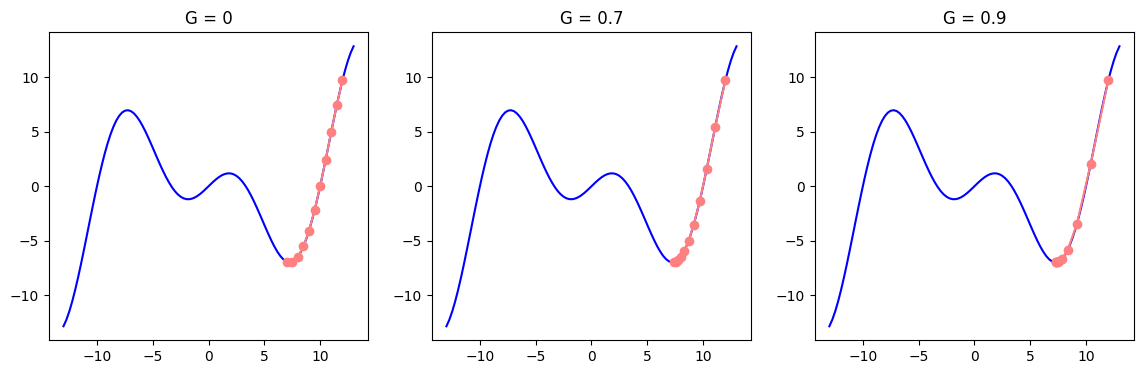

In [ ]:
plot_descent(f, grad_f, point=12, steps=10, start=-13, end=13, learning_rate=0.5, gammas=[0, 0.7, 0.9])

## Adam

You might have noted certain similarities in momentum and RSMProp formulas. But can't we simply make the best out of both worlds and integrate them into a single gradient descent function? It turns out we can. Adam stands for **Adaptive Moment Estimation**. [Adam: A Method for Stochastic Optimization](https://arxiv.org/pdf/1412.6980) does exactly that.

$$
\begin{aligned}
v_t &= \beta_1 v_{t-1} + (1 - \beta_1) \nabla_{\theta} L(\theta_t) \\
s_t &= \beta_2 s_{t-1} + (1 - \beta_2) \nabla_{\theta} L(\theta_t)^2
\end{aligned}
$$

We should note a couple of more things. The common values for weights are $\beta_1=0.9$ and $\beta_2=0.999$ (why not $\beta_2=1.0$ we discussed above), as variance estimate $s_t$ is much slower than the momentum. As we initilize it together with velocity to zero ($v=s=0$) we initially get bias towards smaller values. It can be fixed with normalization:   

$$\hat{v_t} = \frac{v_t}{1 - \beta_1^t}, \quad \hat{s_t} = \frac{s_t}{1 - \beta_2^t}$$

Here $v_t$ and $s_t$ are called moments. Let's see how normalized moments get affected after the first two iterations:

$$
\beta_1 = 0.9^1 = 0.9 \quad \Rightarrow \quad \frac{1}{1 - \beta_1^1} = \frac{1}{0.1} = 10 \\
\beta_1^2 = 0.9^2 = 0.81 \quad \Rightarrow \quad \frac{1}{1 - \beta_1^2} = \frac{1}{0.19} \approx 5.26 \\
\beta_2^1 = 0.999^1 = 0.999 \quad \Rightarrow \quad \frac{1}{1 - \beta_2^1} = \frac{1}{0.001} = 1000 \\
\beta_2^2 = 0.999^2 = 0.998001 \quad \Rightarrow \quad \frac{1}{1 - \beta_2^2} = \frac{1}{0.001999} \approx 500
$$

Finally, we can integrate the accumulated values into our gradient descent formula to get the final step size:

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{s_t}} + \epsilon} \hat{v_t}$$

In [ ]:
def gradient_descent(f, grad_f, learning_rate, initial_point, num_steps, b1=0.9, b2=0.999, normalize=False):
  assert b1 <= 1 and b1 >= 0
  assert b2 <= 1 and b2 >= 0
  path = [initial_point]
  x = initial_point

  v = 0.0
  s = 0.0
  epsilon=1e-8
  for t in range(1, num_steps + 1):
    grad = grad_f(x)
    v = b1 * v + (1 - b1) * grad
    s = b2 * s + (1 - b2) * grad**2
    # as our function and plot are simple, we will keep
    # unnormalized option as well for demonstration purposes
    v_hat = v / (1 - b1**t) if normalize else v
    s_hat = s / (1 - b2**t) if normalize else s
    x -= learning_rate * v_hat / (np.sqrt(s_hat) + epsilon)
    path.append(x)
  return np.array(path)

def plot_descent(f, grad_f, point, steps, start, end, learning_rate, b1_vals=[0.9, 0.99, 0.999], b2_vals=[0.1, 0.99, 0.999], figsize=(14,4)):
  x_vals = np.linspace(start, end, 100)
  y_vals = f(x_vals)

  fig, axs = plt.subplots(len(b1_vals), len(b2_vals), figsize=figsize)
  for i, b1 in enumerate(b1_vals):
    for j, b2 in enumerate(b2_vals):
      path = gradient_descent(f, grad_f, learning_rate, point, steps, b1, b2)
      axs[i, j].plot(x_vals, y_vals, color='b')
      axs[i, j].plot(path, f(path), marker='o', label=f'B1 = {b1}, B2 = {b2}', color=[1.0, 0.5, 0.5])
      axs[i, j].set_title(f'B1 = {b1}, B2 = {b2}')

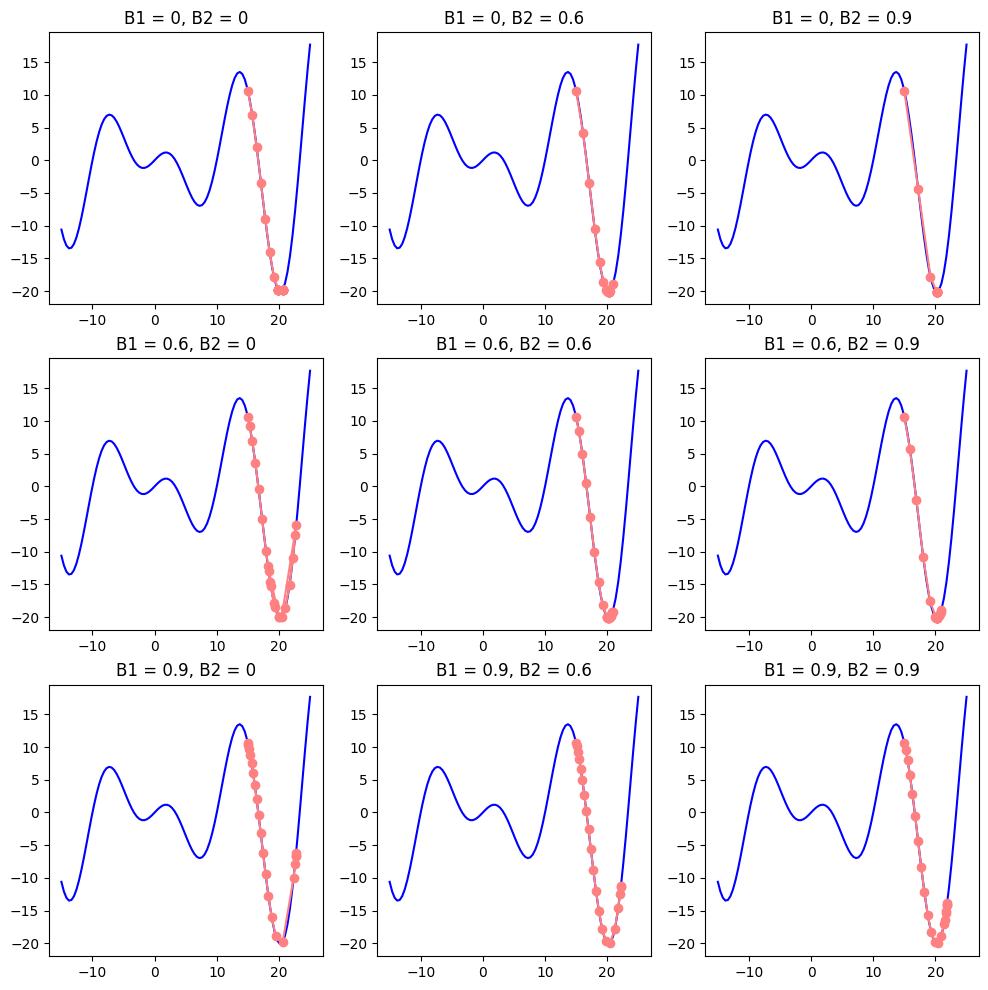

In [ ]:
plot_descent(f, grad_f, point=15, steps=20, start=-15, end=25, learning_rate=0.7, b1_vals=[0, 0.6, 0.9], b2_vals=[0, 0.6, 0.9], figsize=(12, 12))

## CIFAR-10 Dataset

Instead of simple grayscale MNIST dataset, we will choose [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) this time to train our model on. It consists of `50,000` training and `10,000` test images of size `32x32` divided into 10 classes. An alternative version of the dataset called CIFAR-100 has 100 classes. Unlike MNIST, images have three channels (RGB) which makes computation more expensive and the task of the model more difficult.

In [ ]:
from torchvision import datasets, transforms

train_data = datasets.CIFAR10(root='./data', train=True,  download=True, transform=transforms.ToTensor())
test_data  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=64, pin_memory=True, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=64, pin_memory=True, shuffle=False)

In [ ]:
idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}
idx_to_class

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

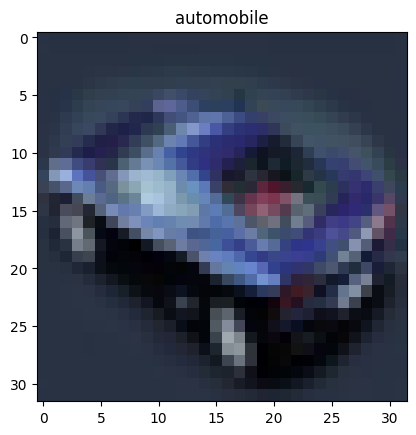

In [ ]:
X_train, y_train = next(iter(train_loader))
plt.imshow(X_train[0].permute(1, 2, 0))
plt.title(idx_to_class[y_train[0].item()]);

## Training Efficient Model

We will now train our custom CNN model (see LeNet model in the previous lecture) by applying regularization / optimization methods we have discussed above. Pay attention to the architecture, try to understand the input dimensions. We have included a `Dropout` layer. In order to initialize our weights non-randomly, we will not use `nn.Lazy` modules.

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 256),
    nn.ReLU(),
    nn.Dropout(0.5), # Dropout
    nn.Linear(256, 10)
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2048, out_features=256, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# Moment weigths are by default 0.9 and 0.999 for Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999), weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Kaiming He Initialization
for layer in model:
  if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
    nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
    if layer.bias is not None:
      nn.init.zeros_(layer.bias)

In [ ]:
model.train()

num_epochs = 50
for epoch in range(num_epochs):
  loss = 0.0
  for X_train, y_train in train_loader:
    X_train, y_train = X_train.to(device), y_train.to(device)
    optimizer.zero_grad()
    preds = model(X_train)
    batch_loss = loss_fn(preds, y_train)
    batch_loss.backward()
    loss += batch_loss.item()
    optimizer.step()
  print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss/len(train_loader):.4f}')

Epoch: 1/50, Loss: 1.6063
Epoch: 2/50, Loss: 1.3142
Epoch: 3/50, Loss: 1.2205
Epoch: 4/50, Loss: 1.1668
Epoch: 5/50, Loss: 1.1335
Epoch: 6/50, Loss: 1.0996
Epoch: 7/50, Loss: 1.0810
Epoch: 8/50, Loss: 1.0594
Epoch: 9/50, Loss: 1.0465
Epoch: 10/50, Loss: 1.0295
Epoch: 11/50, Loss: 1.0175
Epoch: 12/50, Loss: 1.0196
Epoch: 13/50, Loss: 0.9891
Epoch: 14/50, Loss: 0.9799
Epoch: 15/50, Loss: 0.9781
Epoch: 16/50, Loss: 0.9729
Epoch: 17/50, Loss: 0.9789
Epoch: 18/50, Loss: 0.9651
Epoch: 19/50, Loss: 0.9611
Epoch: 20/50, Loss: 0.9605
Epoch: 21/50, Loss: 0.9545
Epoch: 22/50, Loss: 0.9485
Epoch: 23/50, Loss: 0.9362
Epoch: 24/50, Loss: 0.9436
Epoch: 25/50, Loss: 0.9309
Epoch: 26/50, Loss: 0.9296
Epoch: 27/50, Loss: 0.9240
Epoch: 28/50, Loss: 0.9205
Epoch: 29/50, Loss: 0.9164
Epoch: 30/50, Loss: 0.9104
Epoch: 31/50, Loss: 0.9124
Epoch: 32/50, Loss: 0.9160
Epoch: 33/50, Loss: 0.9211
Epoch: 34/50, Loss: 0.9067
Epoch: 35/50, Loss: 0.9168
Epoch: 36/50, Loss: 0.9151
Epoch: 37/50, Loss: 0.9065
Epoch: 38/

In [ ]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
  for X_test, y_test in test_loader:
    X_test, y_test = X_test.to(device), y_test.to(device)
    preds = model(X_test)
    _, predicted = torch.max(preds, 1)
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')

Accuracy on the test set: 68.98%


## Hyperparameter Tuning

When building our model architecture we should consider activation function, number of layers and number of neurons per layer, kernel size, stride, padding. We have also come across to many different hyperparameters up until now: learning rate, batch size, initialization method, number of epochs, optimizer type (e.g. SGD, Adam), momentum (beta values for Adam), weight decay, dropout rate, etc. It is often not very clear which values are the best for our model architecture and dataset. We have to try out many different values for our hyperparameters to find the most efficient training conditions.

**Hyperparameter tuning** is the process of finding the best set of hyperparameters. Grid search, random search, Bayesian optimization help us to explore different hyperparameter combinations. It is recommended to start with common default values, and gradually adjust one or more hyperparameters during experiments. You can use cross-validation to evaluate model performance for each hypermeter combination.

Learning rate and optimizer affect the convergence of training. Batch size and number of epochs affect the training time and model accuracy. Regularization  (dropout, weight decay) parameters should aid with preventing overfitting.

**Exercise:** Tune hyperparameters for the model and note down the results. Which hyperparameter set achieved the best accuracy on test data?